# Master Thesis - Simulated Pick and Place Machine

<img src="simulation_v2.png" width="750">

In [22]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import pandas as pd
import numpy as np
import os
import time
import datetime

import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph

pd.set_option('future.no_silent_downcasting', True)

## Connection to Simulation

In [23]:
client = RemoteAPIClient()

sim = client.require('sim')
simBWF = client.require('simBWF')

inter_script = sim.getObject('/Interventions')

camera_1 = sim.getObject('/camera_1/camera')
camera_2 = sim.getObject('/camera_2/camera')
camera_3 = sim.getObject('/camera_3/camera')
camera_EoL = sim.getObject('/camera_EoL/camera')

conveyor1 = sim.getObject('/genericConveyorTypeA[0]')
conveyor2 = sim.getObject('/genericConveyorTypeA[2]')
conveyor3 = sim.getObject('/genericConveyorTypeA[1]')

rob_1 = sim.getObject('/Ragnar[0]')
rob_2 = sim.getObject('/Ragnar[1]')


# Function names for the different interventions
inter = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2'}


In [24]:
def data_process(data : pd.DataFrame):
    return data.replace(np.nan, 0).replace({True: 1, False: 0})

def data_save_raw(data : pd.DataFrame,run_number:int,timestamp):
    main_dir = 'G:\My Drive\Master Thesis\Simulation\Datasets_raw'  # main directory name
    folder_name = f'Dataset_{run_number}_{timestamp}'
    name = get_var_name(data)
    filename = f'{name}.csv'
    folder_path = os.path.join(main_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    data.to_csv(os.path.join(folder_path, filename), index=False)
    return [filename,folder_path]

def data_save_all(data: pd.DataFrame,run_number:int,type:str,timestamp):
    main_dir = 'G:\My Drive\Master Thesis\Simulation\Dataset'  # main directory name
    folder_name = f'Dataset_{timestamp}'
    filename = f'data_{run_number}_{type}.csv'
    folder_path = os.path.join(main_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    data.to_csv(os.path.join(folder_path, filename), index=False)
    return [filename,folder_path]

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name[:-3]
        
def data_read_save(files):
    camera_1 = pd.read_csv(files[0][1] + '/' + files[0][0])
    camera_1 = camera_1[['sizeX','sizeY']]
    camera_1 = camera_1.rename(columns={'sizeX': 'cam_1_X','sizeY': 'cam_1_Y'})

    camera_2 = pd.read_csv(files[1][1] + '/' + files[1][0])
    camera_2 = camera_2[['sizeX','sizeY']]
    camera_2 = camera_2.rename(columns={'sizeX': 'cam_2_X','sizeY': 'cam_2_Y'})

    data_out = pd.concat([camera_1,camera_2],axis=1)

    camera_3 = pd.read_csv(files[2][1] + '/' + files[2][0])
    camera_3 = camera_3[['sizeX','sizeY']]
    camera_3 = camera_3.rename(columns={'sizeX': 'cam_3_X','sizeY': 'cam_3_Y'})

    data_out = pd.concat([data_out,camera_3],axis=1)

    camera_EoL = pd.read_csv(files[3][1] + '/' + files[3][0])
    camera_EoL = camera_EoL[['part1SizeX','part2SizeX','part3SizeX','part4SizeX',
                             'part1SizeY','part2SizeY','part3SizeY','part4SizeY',
                             'tray1SizeX','tray1SizeY','tray2SizeX','tray2SizeY']]
    camera_EoL = camera_EoL.rename(columns={'part1SizeX':'EoL_3_X','part2SizeX':'EoL_4_X','part3SizeX':'EoL_5_X','part4SizeX':'EoL_6_X',
                                            'part1SizeY':'EoL_3_Y','part2SizeY':'EoL_4_Y','part3SizeY':'EoL_5_Y', 'part4SizeY':'EoL_6_Y',
                                            'tray1SizeX':'EoL_1_X','tray1SizeY':'EoL_1_Y',
                                            'tray2SizeX':'EoL_2_X','tray2SizeY':'EoL_2_Y'})
    
    data_out = pd.concat([data_out,camera_EoL],axis=1)

    conveyor_1 = pd.read_csv(files[4][1] + '/' + files[4][0])
    conveyor_1 = conveyor_1[['speed']]
    conveyor_1 = conveyor_1.rename(columns={'speed':'con_1'})

    data_out = pd.concat([data_out,conveyor_1],axis=1)

    conveyor_2 = pd.read_csv(files[5][1] + '/' + files[5][0])
    conveyor_2 = conveyor_2[['speed']]
    conveyor_2 = conveyor_2.rename(columns={'speed':'con_2'})

    data_out = pd.concat([data_out,conveyor_2],axis=1)

    conveyor_3 = pd.read_csv(files[6][1] + '/' + files[6][0])
    conveyor_3 = conveyor_3[['speed']]
    conveyor_3 = conveyor_3.rename(columns={'speed':'con_3'})

    data_out = pd.concat([data_out,conveyor_3],axis=1)

    rob_1 = pd.read_csv(files[7][1] + '/' + files[7][0])
    rob_1 = rob_1[['jointVelo1','jointVelo2', 'jointVelo4',	'maxVel','gripperPower','jointVelo3']]
    rob_1 = rob_1.rename(columns={'jointVelo1':'rob_1_1','jointVelo2':'rob_1_2','jointVelo3':'rob_1_3','jointVelo4':'rob_1_4',
                                  'maxVel':'rob_1_maxVel','gripperPower':'rob_1_gripper'})
    
    data_out = pd.concat([data_out,rob_1],axis=1)
    
    rob_2 = pd.read_csv(files[8][1] + '/' + files[8][0])
    rob_2 = rob_2[['jointVelo1','jointVelo2', 'jointVelo4',	'maxVel','gripperPower','jointVelo3']]
    rob_2 = rob_2.rename(columns={'jointVelo1':'rob_2_1','jointVelo2':'rob_2_2','jointVelo3':'rob_2_3','jointVelo4':'rob_2_4',
                                  'maxVel':'rob_2_maxVel','gripperPower':'rob_2_gripper'})
    
    data_out = pd.concat([data_out,rob_2],axis=1)

    return data_out
    

In [25]:
duration = 100

run_1 ={'type':'normal'}
run_2 ={'type':'gripper_1'}
run_3 ={'type':'gripper_2'}

simulation = [run_1,run_2,run_3]

run_count = 0

#Timestamp of each simulation
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')

for run in simulation:
    
    camera_1_df = pd.DataFrame()
    camera_2_df = pd.DataFrame()
    camera_3_df = pd.DataFrame()
    camera_EoL_df = pd.DataFrame()

    conveyor_1_df = pd.DataFrame()
    conveyor_2_df = pd.DataFrame()
    conveyor_3_df = pd.DataFrame()

    rob_1_df = pd.DataFrame()
    rob_2_df = pd.DataFrame()

    for type,value in run.items():
        run_count+=1
        if value != 'normal':
            sim.callScriptFunction(inter[value],sim.getScript(sim.scripttype_customizationscript, inter_script))

        print(value)

        sim.setStepping(True)
        sim.startSimulation()
        sim.setBoolParam(sim.boolparam_display_enabled, False)

        while (t := sim.getSimulationTime()) < duration  : # 15 min 36 seconds for 3 runs of 100 seconds
            camera_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_1,'customData'))])
            camera_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_2,'customData'))])
            camera_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_3,'customData'))])
            camera_EoL_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_EoL,'customData'))])

            conveyor_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor1, 'customData'))])
            conveyor_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor2, 'customData'))])
            conveyor_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor3, 'customData'))])

            rob_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(rob_1,'customData'))])
            rob_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(rob_2,'customData'))])

            # detection_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(detectionWindow_1,'customData'))])
            # detection_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(detectionWindow_2,'customData'))])
            # detection_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(detectionWindow_3,'customData'))])
            
            camera_1_df= pd.concat([camera_1_df,camera_1_data], ignore_index=True)
            camera_2_df= pd.concat([camera_2_df,camera_2_data], ignore_index=True)
            camera_3_df= pd.concat([camera_3_df,camera_3_data], ignore_index=True)
            camera_EoL_df= pd.concat([camera_EoL_df,camera_EoL_data], ignore_index=True)


            conveyor_1_df= pd.concat([conveyor_1_df,conveyor_1_data], ignore_index=True)
            conveyor_2_df= pd.concat([conveyor_2_df,conveyor_2_data], ignore_index=True)
            conveyor_3_df= pd.concat([conveyor_3_df,conveyor_3_data], ignore_index=True)

            rob_1_df = pd.concat([rob_1_df,rob_1_data], ignore_index=True)
            rob_2_df = pd.concat([rob_2_df,rob_2_data], ignore_index=True)

            # detection_1_df= pd.concat([detection_1_df,detection_1_data], ignore_index=True)
            # detection_2_df= pd.concat([detection_2_df,detection_2_data], ignore_index=True)
            # detection_3_df= pd.concat([detection_3_df,detection_3_data], ignore_index=True)

            sim.step()

        sim.stopSimulation()

        camera_1_df = data_process(camera_1_df)
        camera_2_df = data_process(camera_2_df)
        camera_3_df = data_process(camera_3_df)
        camera_EoL_df = data_process(camera_EoL_df)

        conveyor_1_df = data_process(conveyor_1_df)
        conveyor_2_df = data_process(conveyor_2_df)
        conveyor_3_df = data_process(conveyor_3_df)

        rob_1_df = data_process(rob_1_df)
        rob_2_df = data_process(rob_2_df)

        files = [
                    data_save_raw(camera_1_df, run_count,timestamp),
                    data_save_raw(camera_2_df, run_count,timestamp),
                    data_save_raw(camera_3_df, run_count,timestamp),
                    data_save_raw(camera_EoL_df, run_count,timestamp),
                    data_save_raw(conveyor_1_df, run_count,timestamp),
                    data_save_raw(conveyor_2_df, run_count,timestamp),
                    data_save_raw(conveyor_3_df, run_count,timestamp),
                    data_save_raw(rob_1_df, run_count,timestamp),
                    data_save_raw(rob_2_df, run_count,timestamp)
                ]
        
        data_out = data_read_save(files)
        data = data_save_all(data_out,run_count,value,timestamp)
        
        time.sleep(5)


normal
gripper_1
gripper_2


In [59]:
data[1]

'G:\\My Drive\\Master Thesis\\Simulation\\Dataset\\Dataset_2024-06-18_18-29-49'

## Combine all data-series

## Causal Graph

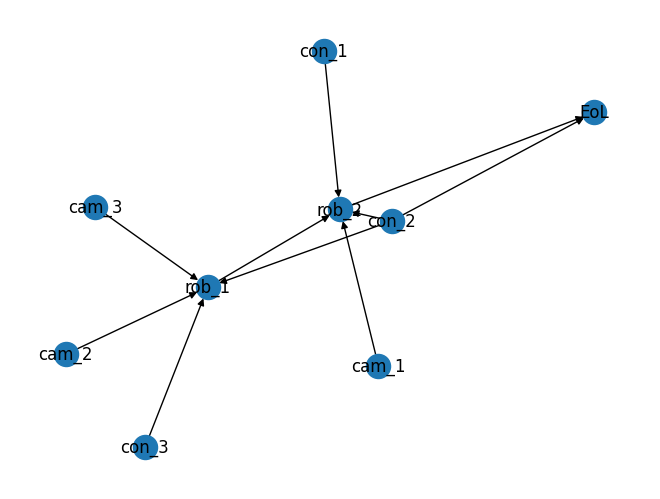

In [56]:
G = nx.DiGraph()

# Sensor - grouped
G.add_node('cam_1')
G.add_node('cam_2')
G.add_node('cam_3')
#G.add_node('cam_4')


G.add_node('con_1')
G.add_node('con_2')
G.add_node('con_3')

G.add_node('rob_1')
G.add_node('rob_2')

G.add_node('EoL')

# Conveyor affect camera

# Robot
G.add_edge('rob_2', 'EoL')
G.add_edge('rob_1', 'rob_2')

# Detection or Robot
G.add_edge('cam_2', 'rob_1')
G.add_edge('cam_3', 'rob_1')
#G.add_edge('cam_4', 'rob_2')
G.add_edge('cam_1', 'rob_2')

G.add_edge('con_1', 'rob_2')
G.add_edge('con_2', 'rob_2')
G.add_edge('con_3', 'rob_1')
G.add_edge('con_2', 'EoL')
G.add_edge('con_2', 'rob_1')

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

## Generate non-lagged extended Causal Graph adjacency matrix

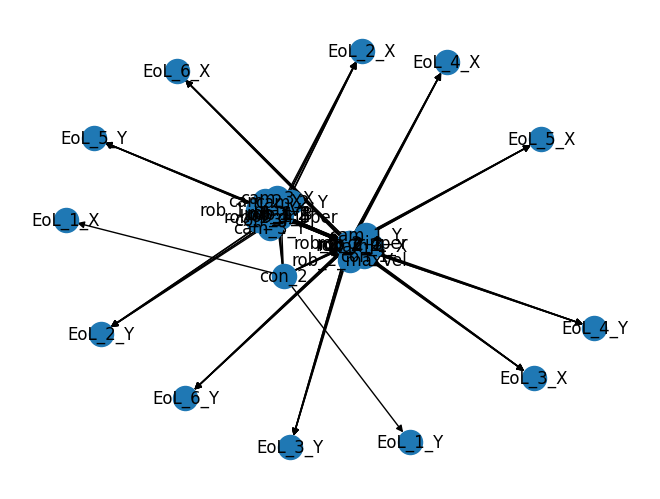

In [157]:
G = nx.DiGraph()

nodes = ['cam_1_X', 'cam_2_X', 'cam_3_X', 
         'cam_1_Y', 'cam_2_Y', 'cam_3_Y', 
         'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
         'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
         'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
         'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
         'rob_1_gripper', 'rob_2_gripper',
         'con_1', 'con_2', 'con_3'
         ]

G.add_nodes_from(nodes)

# Camera to robot joint speeds
G.add_edge('cam_1_X', 'rob_2_1')
G.add_edge('cam_1_Y', 'rob_2_1')
G.add_edge('cam_1_X', 'rob_2_2')
G.add_edge('cam_1_Y', 'rob_2_2')
G.add_edge('cam_1_X', 'rob_2_3')
G.add_edge('cam_1_Y', 'rob_2_3')
G.add_edge('cam_1_X', 'rob_2_4')
G.add_edge('cam_1_Y', 'rob_2_4')

G.add_edge('cam_2_X', 'rob_1_1')
G.add_edge('cam_2_Y', 'rob_1_1')
G.add_edge('cam_2_X', 'rob_1_2')
G.add_edge('cam_2_Y', 'rob_1_2')
G.add_edge('cam_2_X', 'rob_1_3')
G.add_edge('cam_2_Y', 'rob_1_3')
G.add_edge('cam_2_X', 'rob_1_4')
G.add_edge('cam_2_Y', 'rob_1_4')

G.add_edge('cam_3_X', 'rob_1_1')
G.add_edge('cam_3_Y', 'rob_1_1')
G.add_edge('cam_3_X', 'rob_1_2')
G.add_edge('cam_3_Y', 'rob_1_2')
G.add_edge('cam_3_X', 'rob_1_3')
G.add_edge('cam_3_Y', 'rob_1_3')
G.add_edge('cam_3_X', 'rob_1_4')
G.add_edge('cam_3_Y', 'rob_1_4')

#MaxVel to robot joints
G.add_edge('rob_1_maxVel', 'rob_1_1')
G.add_edge('rob_1_maxVel', 'rob_1_2')
G.add_edge('rob_1_maxVel', 'rob_1_3')
G.add_edge('rob_1_maxVel', 'rob_1_4')

G.add_edge('rob_2_maxVel', 'rob_2_1')
G.add_edge('rob_2_maxVel', 'rob_2_2')
G.add_edge('rob_2_maxVel', 'rob_2_3')
G.add_edge('rob_2_maxVel', 'rob_2_4')

#Conveyor speed to robot
G.add_edge('con_2', 'rob_1_1')
G.add_edge('con_2', 'rob_1_2')
G.add_edge('con_2', 'rob_1_3')
G.add_edge('con_2', 'rob_1_4')

G.add_edge('con_3', 'rob_1_1')
G.add_edge('con_3', 'rob_1_2')
G.add_edge('con_3', 'rob_1_3')
G.add_edge('con_3', 'rob_1_4')

G.add_edge('con_2', 'rob_2_1')
G.add_edge('con_2', 'rob_2_2')
G.add_edge('con_2', 'rob_2_3')
G.add_edge('con_2', 'rob_2_4')

G.add_edge('con_2', 'EoL_1_X')
G.add_edge('con_2', 'EoL_1_Y')

G.add_edge('con_1', 'rob_2_1')
G.add_edge('con_1', 'rob_2_2')
G.add_edge('con_1', 'rob_2_3')
G.add_edge('con_1', 'rob_2_4')


#Robot1 to robot2
G.add_edge('rob_1_1', 'rob_2_1')
G.add_edge('rob_1_1', 'rob_2_2')
G.add_edge('rob_1_1', 'rob_2_3')
G.add_edge('rob_1_1', 'rob_2_4')

G.add_edge('rob_1_2', 'rob_2_1')
G.add_edge('rob_1_2', 'rob_2_2')
G.add_edge('rob_1_2', 'rob_2_3')
G.add_edge('rob_1_2', 'rob_2_4')

G.add_edge('rob_1_3', 'rob_2_1')
G.add_edge('rob_1_3', 'rob_2_2')
G.add_edge('rob_1_3', 'rob_2_3')
G.add_edge('rob_1_3', 'rob_2_4')

G.add_edge('rob_1_4', 'rob_2_1')
G.add_edge('rob_1_4', 'rob_2_2')
G.add_edge('rob_1_4', 'rob_2_3')
G.add_edge('rob_1_4', 'rob_2_4')

#No blue tray grippable, no robot movement
G.add_edge('rob_1_gripper', 'rob_2_1')
G.add_edge('rob_1_gripper', 'rob_2_2')
G.add_edge('rob_1_gripper', 'rob_2_3')
G.add_edge('rob_1_gripper', 'rob_2_4')

#Robot 1 to EoL - Blue Tray
G.add_edge('rob_1_1', 'EoL_2_X')
G.add_edge('rob_1_2', 'EoL_2_X')
G.add_edge('rob_1_3', 'EoL_2_X')
G.add_edge('rob_1_4', 'EoL_2_X')

G.add_edge('rob_1_1', 'EoL_2_Y')
G.add_edge('rob_1_2', 'EoL_2_Y')
G.add_edge('rob_1_3', 'EoL_2_Y')
G.add_edge('rob_1_4', 'EoL_2_Y')

G.add_edge('rob_1_gripper', 'EoL_2_X')
G.add_edge('rob_1_gripper', 'EoL_2_Y')

#Robot 2 to EoL - All Green Parts
G.add_edge('rob_2_1', 'EoL_3_Y')
G.add_edge('rob_2_2', 'EoL_3_Y')
G.add_edge('rob_2_3', 'EoL_3_Y')
G.add_edge('rob_2_4', 'EoL_3_Y')

G.add_edge('rob_2_1', 'EoL_3_X')
G.add_edge('rob_2_2', 'EoL_3_X')
G.add_edge('rob_2_3', 'EoL_3_X')
G.add_edge('rob_2_4', 'EoL_3_X')

G.add_edge('rob_2_1', 'EoL_4_X')
G.add_edge('rob_2_2', 'EoL_4_X')
G.add_edge('rob_2_3', 'EoL_4_X')
G.add_edge('rob_2_4', 'EoL_4_X')

G.add_edge('rob_2_1', 'EoL_4_Y')
G.add_edge('rob_2_2', 'EoL_4_Y')
G.add_edge('rob_2_3', 'EoL_4_Y')
G.add_edge('rob_2_4', 'EoL_4_Y')

G.add_edge('rob_2_1', 'EoL_5_X')
G.add_edge('rob_2_2', 'EoL_5_X')
G.add_edge('rob_2_3', 'EoL_5_X')
G.add_edge('rob_2_4', 'EoL_5_X')

G.add_edge('rob_2_1', 'EoL_5_Y')
G.add_edge('rob_2_2', 'EoL_5_Y')
G.add_edge('rob_2_3', 'EoL_5_Y')
G.add_edge('rob_2_4', 'EoL_5_Y')

G.add_edge('rob_2_1', 'EoL_6_X')
G.add_edge('rob_2_2', 'EoL_6_X')
G.add_edge('rob_2_3', 'EoL_6_X')
G.add_edge('rob_2_4', 'EoL_6_X')

G.add_edge('rob_2_1', 'EoL_6_Y')
G.add_edge('rob_2_2', 'EoL_6_Y')
G.add_edge('rob_2_3', 'EoL_6_Y')
G.add_edge('rob_2_4', 'EoL_6_Y')

# No power to grip pieces
G.add_edge('rob_2_gripper', 'EoL_3_X')
G.add_edge('rob_2_gripper', 'EoL_3_Y')

G.add_edge('rob_2_gripper', 'EoL_4_X')
G.add_edge('rob_2_gripper', 'EoL_4_Y')

G.add_edge('rob_2_gripper', 'EoL_5_X')
G.add_edge('rob_2_gripper', 'EoL_5_Y')

G.add_edge('rob_2_gripper', 'EoL_6_X')
G.add_edge('rob_2_gripper', 'EoL_6_Y')

# Draw the graph
nx.draw(G, with_labels=True)

adj_matrix_extended = nx.to_numpy_array(G)
adj_matrix_extended

file_path = os.path.join(data[1], 'true_no_lagged_graph_extendend.csv')
np.savetxt(file_path,adj_matrix_extended,delimiter=',')


## Visualisation of the extended no-lagged causal graph

In [152]:
g_ext = Digraph('G', filename='output', format='png')

nodes = [
    'cam_1_X', 'cam_2_X', 'cam_3_X',
    'cam_1_Y', 'cam_2_Y', 'cam_3_Y',
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
    'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
    'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
    'rob_1_gripper', 'rob_2_gripper',
    'con_1','con_2','con_3'
]

edges = [
    ('cam_1_X', 'rob_2_1'), ('cam_1_Y', 'rob_2_1'),
    ('cam_1_X', 'rob_2_2'), ('cam_1_Y', 'rob_2_2'),
    ('cam_1_X', 'rob_2_3'), ('cam_1_Y', 'rob_2_3'),
    ('cam_1_X', 'rob_2_4'), ('cam_1_Y', 'rob_2_4'),
    
    ('cam_2_X', 'rob_1_1'), ('cam_2_Y', 'rob_1_1'),
    ('cam_2_X', 'rob_1_2'), ('cam_2_Y', 'rob_1_2'),
    ('cam_2_X', 'rob_1_3'), ('cam_2_Y', 'rob_1_3'),
    ('cam_2_X', 'rob_1_4'), ('cam_2_Y', 'rob_1_4'),
    
    ('cam_3_X', 'rob_1_1'), ('cam_3_Y', 'rob_1_1'),
    ('cam_3_X', 'rob_1_2'), ('cam_3_Y', 'rob_1_2'),
    ('cam_3_X', 'rob_1_3'), ('cam_3_Y', 'rob_1_3'),
    ('cam_3_X', 'rob_1_4'), ('cam_3_Y', 'rob_1_4'),
    
    ('rob_1_maxVel', 'rob_1_1'), ('rob_1_maxVel', 'rob_1_2'),
    ('rob_1_maxVel', 'rob_1_3'), ('rob_1_maxVel', 'rob_1_4'),
    
    ('rob_2_maxVel', 'rob_2_1'), ('rob_2_maxVel', 'rob_2_2'),
    ('rob_2_maxVel', 'rob_2_3'), ('rob_2_maxVel', 'rob_2_4'),
    
    ('con_2', 'rob_1_1'), ('con_2', 'rob_1_2'), ('con_2', 'rob_1_3'), ('con_2', 'rob_1_4'),
    ('con_3', 'rob_1_1'), ('con_3', 'rob_1_2'), ('con_3', 'rob_1_3'), ('con_3', 'rob_1_4'),

    ('con_2', 'rob_2_1'), ('con_2', 'rob_2_2'), ('con_2', 'rob_2_3'), ('con_2', 'rob_2_4'),
    ('con_1', 'rob_2_1'), ('con_1', 'rob_2_2'), ('con_1', 'rob_2_3'), ('con_1', 'rob_2_4'),

    ('con_2', 'EoL_1_X'), ('con_2', 'EoL_1_Y'),
    
    ('rob_1_1', 'rob_2_1'), ('rob_1_1', 'rob_2_2'), ('rob_1_1', 'rob_2_3'), ('rob_1_1', 'rob_2_4'),
    ('rob_1_2', 'rob_2_1'), ('rob_1_2', 'rob_2_2'), ('rob_1_2', 'rob_2_3'), ('rob_1_2', 'rob_2_4'),
    ('rob_1_3', 'rob_2_1'), ('rob_1_3', 'rob_2_2'), ('rob_1_3', 'rob_2_3'), ('rob_1_3', 'rob_2_4'),
    ('rob_1_4', 'rob_2_1'), ('rob_1_4', 'rob_2_2'), ('rob_1_4', 'rob_2_3'), ('rob_1_4', 'rob_2_4'),
    
    ('rob_1_gripper', 'rob_2_1'), ('rob_1_gripper', 'rob_2_2'),
    ('rob_1_gripper', 'rob_2_3'), ('rob_1_gripper', 'rob_2_4'),

    ('rob_1_1', 'EoL_2_X'), ('rob_1_2', 'EoL_2_X'),
    ('rob_1_3', 'EoL_2_X'), ('rob_1_4', 'EoL_2_X'),
    ('rob_1_1', 'EoL_2_Y'), ('rob_1_2', 'EoL_2_Y'),
    ('rob_1_3', 'EoL_2_Y'), ('rob_1_4', 'EoL_2_Y'),
    
    ('rob_2_1', 'EoL_3_X'), ('rob_2_2', 'EoL_3_X'),
    ('rob_2_3', 'EoL_3_X'), ('rob_2_4', 'EoL_3_X'),
    ('rob_2_1', 'EoL_3_Y'), ('rob_2_2', 'EoL_3_Y'),
    ('rob_2_3', 'EoL_3_Y'), ('rob_2_4', 'EoL_3_Y'),
    
    ('rob_2_1', 'EoL_4_X'), ('rob_2_2', 'EoL_4_X'),
    ('rob_2_3', 'EoL_4_X'), ('rob_2_4', 'EoL_4_X'),
    ('rob_2_1', 'EoL_4_Y'), ('rob_2_2', 'EoL_4_Y'),
    ('rob_2_3', 'EoL_4_Y'), ('rob_2_4', 'EoL_4_Y'),
    
    ('rob_2_1', 'EoL_5_X'), ('rob_2_2', 'EoL_5_X'),
    ('rob_2_3', 'EoL_5_X'), ('rob_2_4', 'EoL_5_X'),
    ('rob_2_1', 'EoL_5_Y'), ('rob_2_2', 'EoL_5_Y'),
    ('rob_2_3', 'EoL_5_Y'), ('rob_2_4', 'EoL_5_Y'),

    ('rob_2_1', 'EoL_6_X'), ('rob_2_2', 'EoL_6_X'),
    ('rob_2_3', 'EoL_6_X'), ('rob_2_4', 'EoL_6_X'),
    ('rob_2_1', 'EoL_6_Y'), ('rob_2_2', 'EoL_6_Y'),
    ('rob_2_3', 'EoL_6_Y'), ('rob_2_4', 'EoL_6_Y'),

    ('rob_1_gripper', 'EoL_2_X'), ('rob_1_gripper', 'EoL_2_Y'),
    
    ('rob_2_gripper', 'EoL_3_X'), ('rob_2_gripper', 'EoL_3_Y'),
    ('rob_2_gripper', 'EoL_4_X'), ('rob_2_gripper', 'EoL_4_Y'),
    ('rob_2_gripper', 'EoL_5_X'), ('rob_2_gripper', 'EoL_5_Y'),
    ('rob_2_gripper', 'EoL_6_X'), ('rob_2_gripper', 'EoL_6_Y'),
]



In [155]:
# Create an adjacency matrix
num_nodes = len(nodes)
adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Create a mapping from node names to their indices
node_index_map = {node: idx for idx, node in enumerate(nodes)}

# Populate the adjacency matrix using the edges
for edge in edges:
    source_node, target_node = edge
    source_idx = node_index_map[source_node]
    target_idx = node_index_map[target_node]
    adj_matrix[source_idx, target_idx] = 1


### Check if both adjacency matrixes are equivalent

In [156]:
adj_array1 = np.array(adj_matrix_extended)
adj_array2 = np.array(adj_matrix)

diff_matrix = adj_array1-adj_array2
print(np.all(diff_matrix == 0))

True


In [147]:
g_ext.attr(rankdir='TB')
g_ext.attr(ranksep='2 equally')
g_ext.attr(newrank='True')
g_ext.attr(center='True')

rob_1_nodes = [node for node in nodes if node.startswith('rob_1')]
rob_2_nodes = [node for node in nodes if node.startswith('rob_2')]
cam_1_nodes = [node for node in nodes if node.startswith('cam_1')]
cam_2_nodes = [node for node in nodes if node.startswith('cam_2')]
cam_3_nodes = [node for node in nodes if node.startswith('cam_3')]
con_nodes = [node for node in nodes if node.startswith('con')]
EoL_nodes = [node for node in nodes if node.startswith('EoL')]

with g_ext.subgraph(name='cluster_cam_1') as c1:
    c1.attr(label='Camera System 1')
    c1.attr(rank='source',bgcolor='lightblue')
    for node in cam_1_nodes:
        c1.node(node)

with g_ext.subgraph(name='cluster_cam_2') as c2:
    c2.attr(label='Camera System 2')
    c2.attr(rank='source',bgcolor='lightblue')
    for node in cam_2_nodes:
        c2.node(node)

with g_ext.subgraph(name='cluster_cam_3') as c3:
    c3.attr(label='Camera System 3')
    c3.attr(rank='source',bgcolor='lightblue')
    for node in cam_3_nodes:
        c3.node(node)

with g_ext.subgraph(name='cluster_con') as c4:
    c4.attr(label='Conveyors')
    c4.attr(rank='source',bgcolor='lightgrey')
    for node in con_nodes:
        c4.node(node)

with g_ext.subgraph(name='cluster_rob_1') as c5:
    c5.attr(label='Robotic System 1',bgcolor='lightyellow')
    c5.attr(rank='min')
    for node in rob_1_nodes:
        c5.node(node)

with g_ext.subgraph(name='cluster_rob_2') as c6:
    c6.attr(label='Robotic System 2',bgcolor='lightyellow')
    c6.attr(rank='max')
    for node in rob_2_nodes:
        c6.node(node)


with g_ext.subgraph(name='cluster_EoL') as c7:
    c7.attr(label='End of Line',bgcolor='lightgreen')
    c7.attr(rank='sink')
    for node in EoL_nodes:
        c7.node(node)


for edge in edges:
    g_ext.edge(edge[0], edge[1])

g_ext.render('output_extended',format='png', view=True)


'output_extended.png'

In [148]:
g_simp = Digraph()

nodes = [
    ('cam_1', 'Camera 1'),
    ('cam_2', 'Camera 2'),
    ('cam_3', 'Camera 3'),
    ('con_1', 'Conveyor 1'),
    ('con_2', 'Conveyor 2'),
    ('con_3', 'Conveyor 3'),
    ('rob_1', 'Robot 1'),
    ('rob_2', 'Robot 2'),
    ('EoL', 'End of Line')
]

edges = [
    ('rob_2', 'EoL'),
    ('rob_1', 'rob_2'),
    ('cam_2', 'rob_1'),
    ('cam_3', 'rob_1'),
    ('cam_1', 'rob_2'),
    
    ('con_1', 'rob_2'),
    ('con_2', 'rob_2'),
    ('con_3', 'rob_1'),
    ('con_2', 'rob_1'),
    ('rob_1', 'EoL'),
    ('con_2', 'EoL'),
]

for node, label in nodes:
    if node.startswith('cam'):
        g_simp.node(node, label, style='filled', color='lightblue')
    elif node.startswith('con'):
        g_simp.node(node, label, style='filled', color='lightgrey')
    elif node.startswith('rob'):
        g_simp.node(node, label, style='filled', color='lightyellow')
    elif node == 'EoL':
        g_simp.node(node, label, style='filled', color='lightgreen')

for edge in edges:
    g_simp.edge(edge[0], edge[1])

g_simp.render('output_simplified', format='png', view=True)

'output_simplified.png'

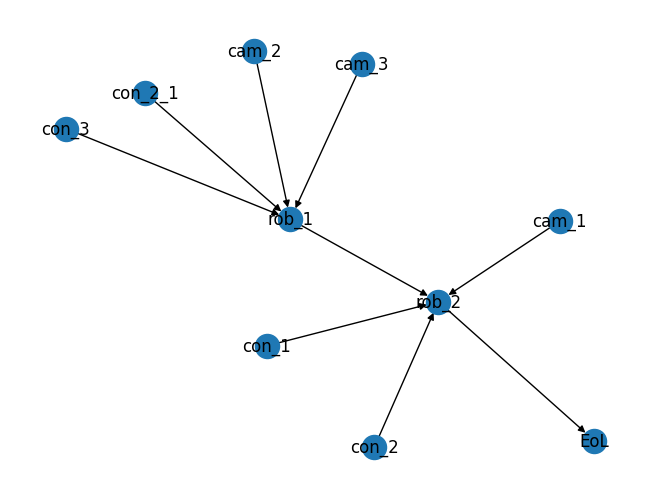

In [32]:
G = nx.DiGraph()

# Sensor - grouped
G.add_node('cam_1')
G.add_node('cam_2')
G.add_node('cam_3')
#G.add_node('cam_4')


G.add_node('con_1')
G.add_node('con_2')
G.add_node('con_3')

G.add_node('rob_1')
G.add_node('rob_2')


G.add_node('EoL')

# Conveyor affect camera

# Robot
G.add_edge('rob_2', 'EoL')
G.add_edge('rob_1', 'rob_2')

# Detection or Robot
G.add_edge('cam_2', 'rob_1')
G.add_edge('cam_3', 'rob_1')
#G.add_edge('cam_4', 'rob_2')
G.add_edge('cam_1', 'rob_2')

G.add_edge('con_1', 'rob_2')
G.add_edge('con_2', 'rob_2')
G.add_edge('con_3', 'rob_1')
G.add_edge('con_2_1', 'rob_1')

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

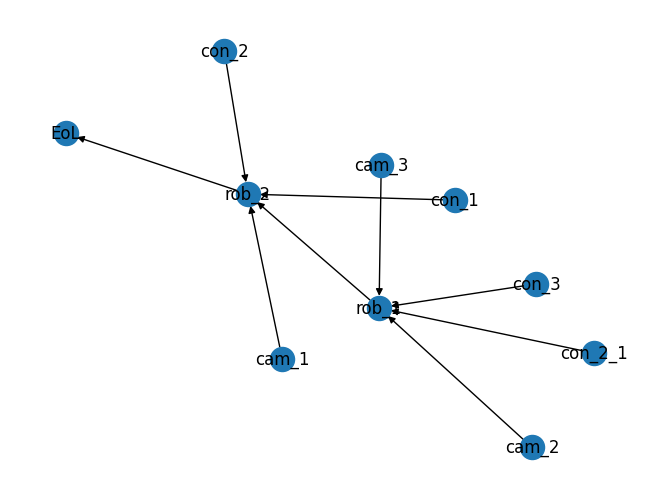

In [33]:
G = nx.DiGraph()

# Sensor - grouped
G.add_node('cam_1')
G.add_node('cam_2')
G.add_node('cam_3')
#G.add_node('cam_4')

G.add_node('con_1')
G.add_node('con_2')
G.add_node('con_3')

G.add_node('rob_1')
G.add_node('rob_2')
G.add_node('EoL')

# Conveyor affect camera

# Robot
G.add_edge('rob_2', 'EoL')
G.add_edge('rob_1', 'rob_2')

# Detection or Robot
G.add_edge('cam_2', 'rob_1')
G.add_edge('cam_3', 'rob_1')
#G.add_edge('cam_4', 'rob_2')
G.add_edge('cam_1', 'rob_2')

G.add_edge('con_1', 'rob_2')
G.add_edge('con_2', 'rob_2')
G.add_edge('con_3', 'rob_1')
G.add_edge('con_2_1', 'rob_1')

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

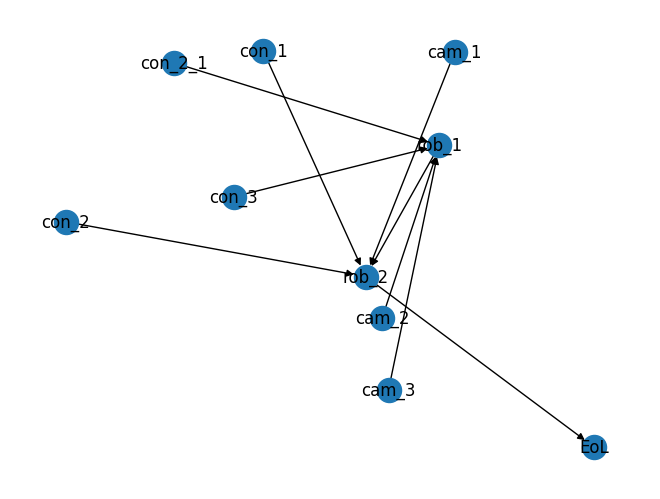

In [34]:
G = nx.DiGraph()

# Sensor - grouped
G.add_node('cam_1')
G.add_node('cam_2')
G.add_node('cam_3')
#G.add_node('cam_4')


G.add_node('con_1')
G.add_node('con_2')
G.add_node('con_3')

G.add_node('rob_1')
G.add_node('rob_2')


G.add_node('EoL')

# Conveyor affect camera

# Robot
G.add_edge('rob_2', 'EoL')
G.add_edge('rob_1', 'rob_2')

# Detection or Robot
G.add_edge('cam_2', 'rob_1')
G.add_edge('cam_3', 'rob_1')
#G.add_edge('cam_4', 'rob_2')
G.add_edge('cam_1', 'rob_2')

G.add_edge('con_1', 'rob_2')
G.add_edge('con_2', 'rob_2')
G.add_edge('con_3', 'rob_1')
G.add_edge('con_2_1', 'rob_1')

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

## Plots of Camera

Text(0, 0.5, 'Frequency')

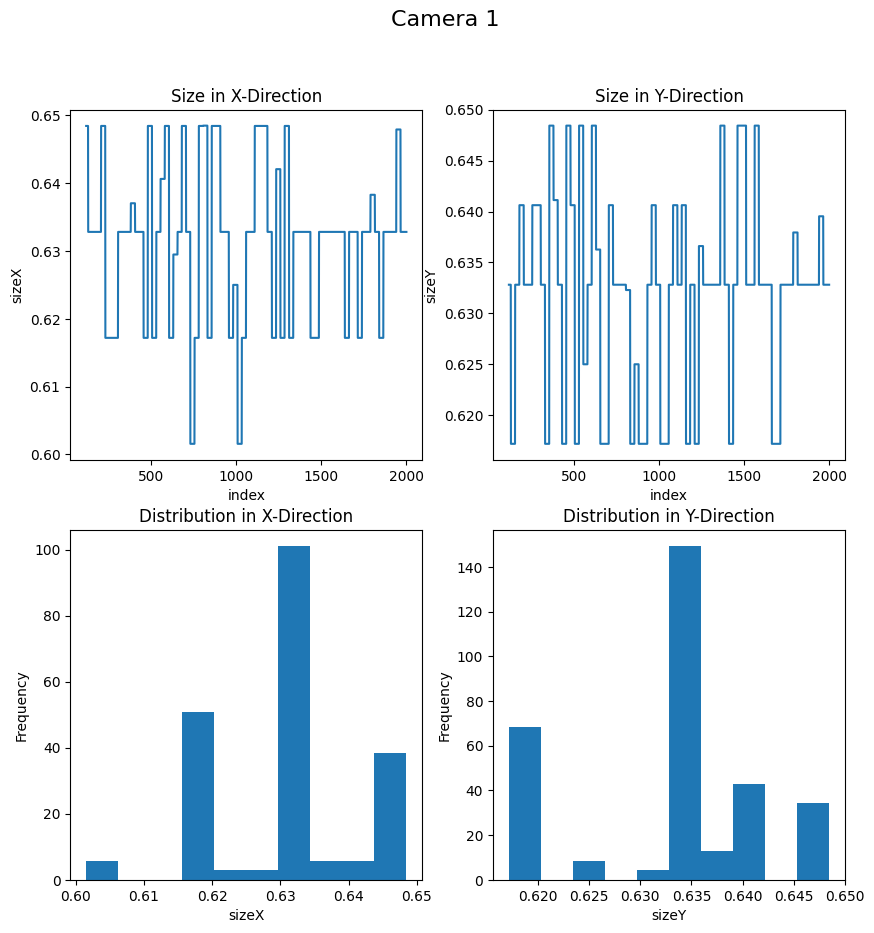

In [35]:
fig,axs = plt.subplots(2,2,figsize = (10,10))
fig.suptitle('Camera 1',fontsize=16)

axs[0,0].plot(camera_1_df['sizeX'][116:8000])
axs[0,1].plot(camera_1_df['sizeY'][116:8000])
axs[1,0].hist(camera_1_df['sizeX'][116:8000], density = True)
axs[1,1].hist(camera_1_df['sizeY'][116:8000], density = True)

axs[0, 0].set_title('Size in X-Direction')
axs[0, 0].set_xlabel('index')
axs[0, 0].set_ylabel('sizeX')

axs[0, 1].set_title('Size in Y-Direction')
axs[0, 1].set_xlabel('index')
axs[0, 1].set_ylabel('sizeY')

axs[1, 0].set_title('Distribution in X-Direction')
axs[1, 0].set_xlabel('sizeX')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].set_title('Distribution in Y-Direction')
axs[1, 1].set_xlabel('sizeY')
axs[1, 1].set_ylabel('Frequency')


Text(0, 0.5, 'Frequency')

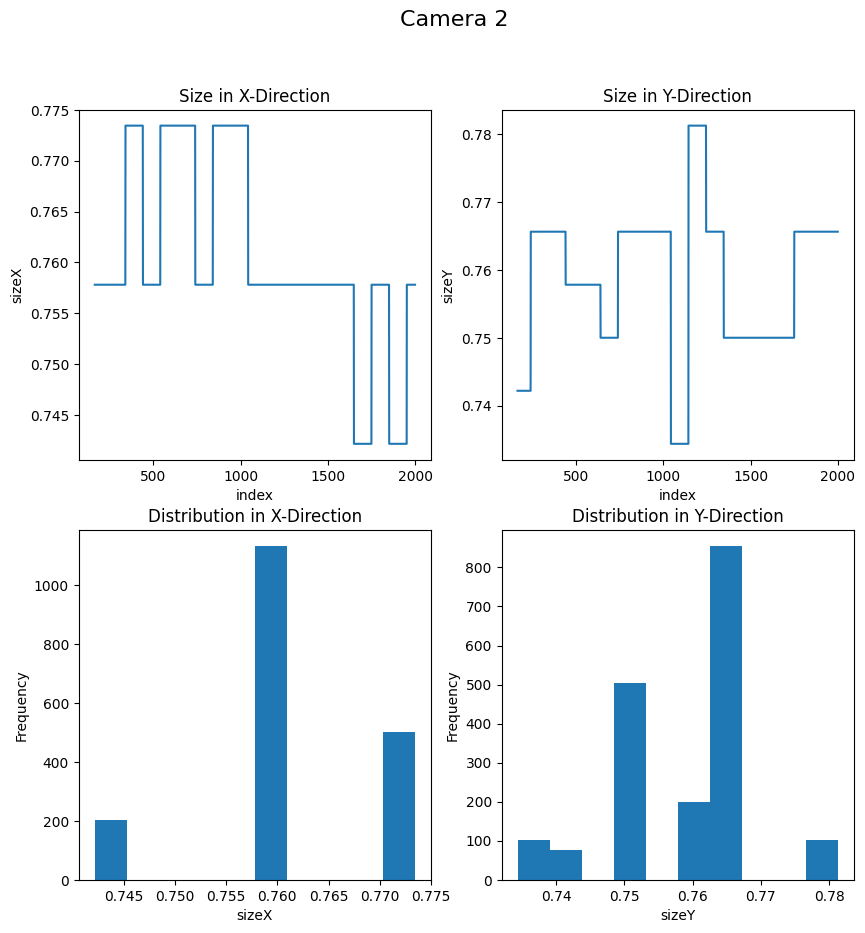

In [36]:
fig,axs = plt.subplots(2,2,figsize = (10,10))
fig.suptitle('Camera 2',fontsize=16)

axs[0,0].plot(camera_2_df['sizeX'][165:8000])
axs[0,1].plot(camera_2_df['sizeY'][165:8000])
axs[1,0].hist(camera_2_df['sizeX'][165:8000])
axs[1,1].hist(camera_2_df['sizeY'][165:8000])

axs[0, 0].set_title('Size in X-Direction')
axs[0, 0].set_xlabel('index')
axs[0, 0].set_ylabel('sizeX')

axs[0, 1].set_title('Size in Y-Direction')
axs[0, 1].set_xlabel('index')
axs[0, 1].set_ylabel('sizeY')

axs[1, 0].set_title('Distribution in X-Direction')
axs[1, 0].set_xlabel('sizeX')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].set_title('Distribution in Y-Direction')
axs[1, 1].set_xlabel('sizeY')
axs[1, 1].set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

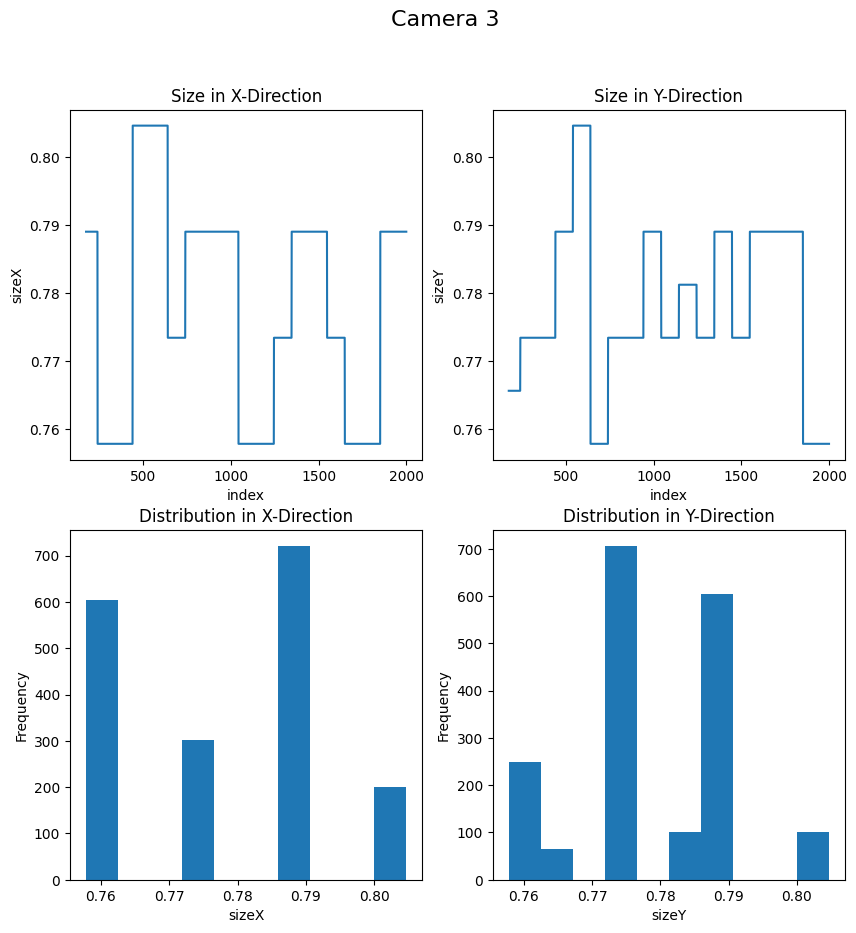

In [37]:
fig,axs = plt.subplots(2,2,figsize = (10,10))
fig.suptitle('Camera 3',fontsize=16)

axs[0,0].plot(camera_3_df['sizeX'][175:8000])
axs[0,1].plot(camera_3_df['sizeY'][175:8000])
axs[1,0].hist(camera_3_df['sizeX'][175:8000])
axs[1,1].hist(camera_3_df['sizeY'][175:8000])

axs[0, 0].set_title('Size in X-Direction')
axs[0, 0].set_xlabel('index')
axs[0, 0].set_ylabel('sizeX')

axs[0, 1].set_title('Size in Y-Direction')
axs[0, 1].set_xlabel('index')
axs[0, 1].set_ylabel('sizeY')

axs[1, 0].set_title('Distribution in X-Direction')
axs[1, 0].set_xlabel('sizeX')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].set_title('Distribution in Y-Direction')
axs[1, 1].set_xlabel('sizeY')
axs[1, 1].set_ylabel('Frequency')

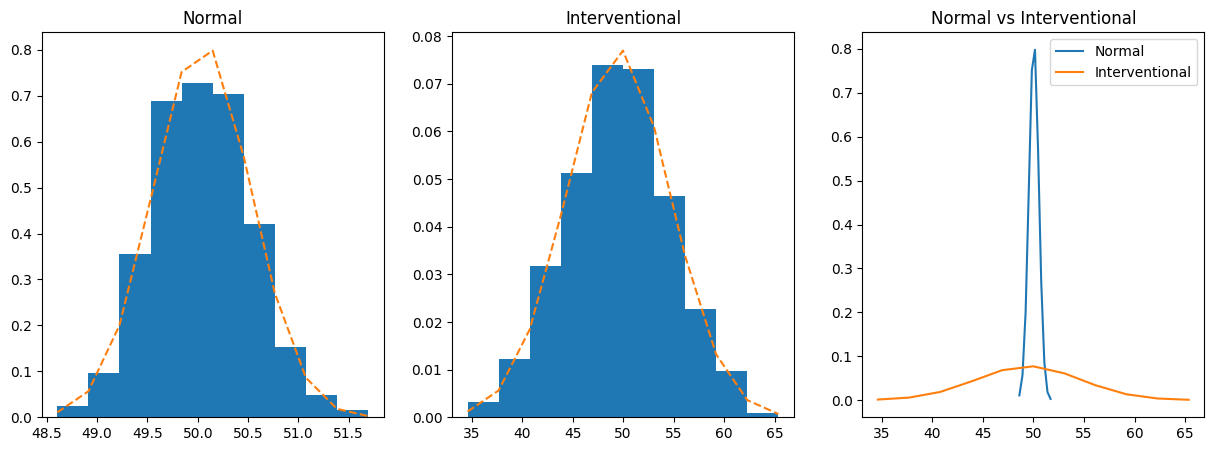

In [38]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(int((time.time())))
U1 = np.random.uniform(size = 400)
U2 = np.random.uniform(size = 400)
R = np.sqrt(-2 * np.log(U1))
Theta = 2 * np.pi * U2
X = R * np.cos(Theta)*0.5 + 50
Y = R * np.sin(Theta)*5 + 50
varX = np.var(X)
varY = np.var(Y)
avX = np.average(X)
avY = np.average(Y)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,5))
nX, binsX, patchesX= ax1.hist(X, density = True)
ax1.set_title('Normal')

fitX = ((1 / (np.sqrt(2 * np.pi) * np.sqrt(varX))) *np.exp(-0.5 * (1 / np.sqrt(varX) * (binsX - avX))**2))
ax1.plot(binsX, fitX, '--')

nY, binsY, patchesY = ax2.hist(Y, density = True)
ax2.set_title('Interventional')
fitY = ((1 / (np.sqrt(2 * np.pi) * np.sqrt(varY))) *np.exp(-0.5 * (1 / np.sqrt(varY) * (binsY - avY))**2))
ax2.plot(binsY, fitY, '--')

ax3.set_title('Normal vs Interventional')
ax3.plot(binsX, fitX, '-', label='Normal')
ax3.plot(binsY, fitY, '-', label = 'Interventional')
ax3.legend(loc='upper right')

plt.legend()
plt.show()

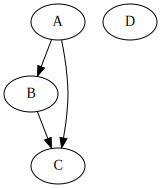

In [39]:

from graphviz import Digraph

g = Digraph()
g.edge('B', 'C')
g.node('D')
g.edge('A', 'B')
g.edge('A', 'C')

g.format = 'png'
#g.render('causal_graph')
g



In [40]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

# Create a StructureModel (initially empty)
sm = StructureModel()

# Add nodes
sm.add_nodes_from(['A', 'B', 'C'])

# Add edges (directed links)
sm.add_edge('A', 'B')
sm.add_edge('B', 'C')

# Visualize the structure (optional)
viz = plot_structure(sm, graph_attributes={'scale': '0.5'},
                     all_node_attributes=NODE_STYLE.WEAK,
                     all_edge_attributes=EDGE_STYLE.WEAK)
viz.draw('images/bn_graph.png')

# Create a Bayesian Network from the StructureModel
bn = BayesianNetwork(sm)

# Plot the Bayesian Network (DAG)
viz.draw()


ModuleNotFoundError: No module named 'causalnex'

In [ ]:
import numpy as np
import pandas as pd
import lingam
from lingam.utils import make_dot

# Generate sample data
x3 = np.random.uniform(size=10000)
x0 = 3.0 * x3 + np.random.uniform(size=10000)
x2 = 6.0 * x3 + np.random.uniform(size=10000)
x1 = 3.0 * x0 + 2.0 * x2 + np.random.uniform(size=10000)
x5 = 4.0 * x0 + np.random.uniform(size=10000)
x4 = 8.0 * x0 - 1.0 * x2 + np.random.uniform(size=10000)

# Create DataFrame
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

# Fit DirectLiNGAM model
model = lingam.DirectLiNGAM()
model.fit(X)

# Create graph
g_simp = make_g_simp(model.adjacency_matrix_, labels=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

# Specify the format and render the graph
g_simp.format = 'png'  # or 'pdf', 'jpeg', etc.
g_simp.render('lingam_graph')
